# Mktcap, Size, BM

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import statsmodels.api as sm
path = os.getcwd()

D:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Mktcap&Size

In [3]:
#全市场所有股票对应的Market Capital和size指标的构造
crsp = pd.read_csv(os.path.join(path, '数据', 'size_bm_mom_crsp_m.csv'))
crsp.head()

FileNotFoundError: [Errno 2] File b'D:/Postgraduate/2020/asset pricing/data/size_bm_mom_crsp_m.csv' does not exist: b'D:/Postgraduate/2020/asset pricing/data/size_bm_mom_crsp_m.csv'

In [4]:
#US-based common stock filter
crsp[['shrcd']]=crsp[['shrcd']].astype('int')
crsp = crsp[(crsp['shrcd'] == 11) | (crsp['shrcd'] == 10)]

NameError: name 'crsp' is not defined

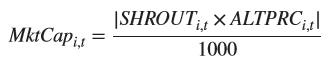

In [19]:
# calculate market equity
crsp['me'] = crsp['prc'].abs()*crsp['shrout']/1000 
crsp.sort_values(by = ['date','permco','me'],inplace = True)

#change date format
crsp['date']=pd.to_datetime(crsp['date'])
crsp['year']=crsp['date'].dt.year
crsp['month']=crsp['date'].dt.month

# keep December data
decme = crsp[crsp['month']==12]
decme['size'] = np.log(decme['me'])
decme = decme[['year','me','size']]
decme = decme[(decme['year'] >= 1988) & (decme['year']<=2012)]
mrtcap_size = decme.groupby('year')

D:\Python\anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## BM=BE/ME

In [20]:
# 为了构造BM首先处理公司的加总market equity
crsp_summe = crsp.groupby(['date','permco'])['me'].sum().reset_index()
crsp_summe.rename(columns = {'me':'me_sum'},inplace = True)
crsp2 = pd.merge(crsp, crsp_summe, how = 'inner', on = ['date','permno'])

# sort by permno and date and also drop duplicates
crsp2 = crsp2.sort_values(by = ['permco','date']).drop_duplicates()
crsp2 = crsp2[crsp2['month'] == 12]

In [21]:
#计算Book Equity
comp = pd.read_csv(os.path.join(path, '数据', 'size_bm_mom_comp.csv'))
comp.head()

,Unnamed: 0,gvkey,datadate,cusip,sich,seq,pstkrv,pstkl,pstk,txdb,itcb
0,0,1000,1970/12/31,32102,NaN,10.544,0.0,0.0,0.0,0.000,0.0
1,1,1000,1971/12/31,32102,NaN,8.382,0.0,0.0,0.0,0.000,0.0
2,2,1000,1972/12/31,32102,NaN,7.021,0.0,0.0,0.0,0.288,0.0
3,3,1187,1970/12/31,8482101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1000,1973/12/31,32102,NaN,8.567,0.0,0.0,0.0,0.231,0.0


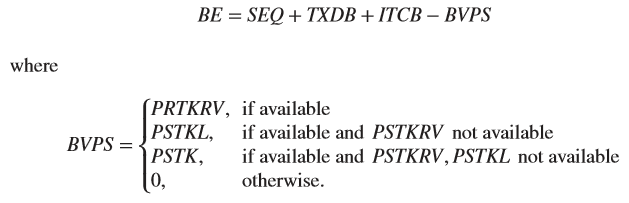

In [22]:
#convert datadate to date fmt
comp['datadate'] = pd.to_datetime(comp['datadate']) 
comp['year'] = comp['datadate'].dt.year

# create preferrerd stock
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps'] = np.where(comp['ps'].isnull(), comp['pstk'], comp['ps'])
comp['ps'] = np.where(comp['ps'].isnull(), 0, comp['ps'])
comp['txdb'] = comp['txdb'].fillna(0)
# create book equity
comp['be'] = comp['seq'] + comp['txdb'] + comp['itcb'] - comp['ps']

In [23]:
#将me与be通过中介表格ccm匹配
ccm = pd.read_csv(os.path.join(path, '数据','size_bm_mom_ccm.csv',index_col=0)
ccm['LINKDT']=pd.to_datetime(ccm['LINKDT'], format = '%Y%m%d')
ccm['LINKENDDT']=np.where(ccm['LINKENDDT'].str.isnumeric(), ccm['LINKENDDT'], '20200229')
ccm['LINKENDDT']=pd.to_datetime(ccm['LINKENDDT'], format = '%Y%m%d')
ccm.head()

,gvkey,permco,linktype,linkprim,linkdt,linkenddt
0,1000,23369.0,LU,P,1970-11-13,1978-06-30
1,1001,6398.0,LU,P,1983-09-20,1986-07-31
2,1002,22159.0,LC,C,1972-12-14,1973-06-05
3,1003,6672.0,LU,C,1983-12-07,1989-08-16
4,1004,20000.0,LU,P,1972-04-24,NaN


In [24]:
#comp(be)与ccm匹配
ccm.rename(columns={'LPERMNO':'permno'},inplace = True)
ccm1=pd.merge(comp[['gvkey','datadate','year','be']],ccm,how='left',on=['gvkey'])
ccm1=ccm1[(ccm1['datadate']>=ccm1['LINKDT'])&(ccm1['datadate']<=ccm1['LINKENDDT'])]
ccm1=ccm1[['gvkey','permno','datadate','year','be']]
ccm1.rename(columns={'datadate':'date'},inplace = True)

#ccm1与crsp(me)匹配
ccm2 = pd.merge(crsp2, ccm1, how='inner', on=['permno', 'year']).drop_duplicates()
ccm2 = ccm2[ccm2['me_sum'] != 0]
ccm2['bm']=ccm2['be']/ccm2['me_sum']
ccm3 = ccm2[['year','bm']]
ccm3 = ccm3[ccm3['year']<=2012]
bm = ccm3.groupby('year')

In [1]:
#对分组进行计算求平均
def status(groupdata,dataname) : 
    x = groupdata[dataname]
    temp = []
    for i in range(1988,2013):
        temp.append(x.get_group(i).kurt())
    kurt_num = np.mean(temp)
    return pd.Series([x.mean().mean(),x.std().mean(),x.skew().mean(),kurt_num,x.min().mean(),x.quantile(.05).mean(),x.quantile(.25).mean(),x.median().mean(),
                      x.quantile(.75).mean(),x.quantile(.95).mean(),x.max().mean(),x.count().mean()],
                      index=['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'])
df = pd.DataFrame([])
df['MrtCap'] = status(mrtcap_size,'me')
df['Size'] = status(mrtcap_size,'size')
df['BM'] = status(bm,'bm')
df = df.apply(lambda x:round(x, 2))
print(df)


NameError: name 'pd' is not defined

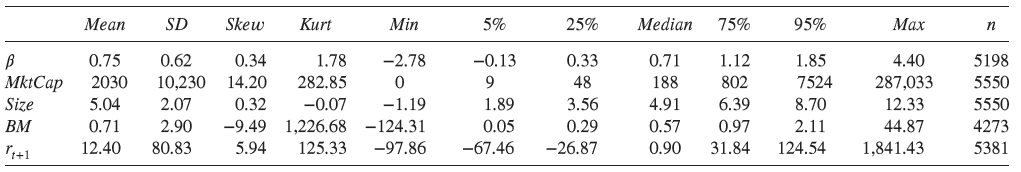

In [ ]:
#下面计算r_t+1

In [ ]:
ff=pd.read_csv(os.path.join(path, '数据','F-F_Year_Factors.csv',header=0,index_col=0) #导入年度无风险利率
data=crsp[['permno','year','month','ret']] 
data=data.dropna() #删除缺失值
data=data[data['ret']!='C'] #有些数据为C
data[['ret']]=data[['ret']].astype(float)  #把ret转成数值
data1 = data[(data['year'] >= 1989) & (data['year']<=2012)]      #r_t+1的时间区间与其他指标不同         

In [ ]:
data1['ret2']=data1['ret']+1
data2 = (data1['ret2'].groupby([data1['year'], data1['permno']]).prod()-1)*100#根据year和permno分组对ret2连乘求积
data2 = data2.reset_index() #重置索引，将原有索引转成列
data2 = data2.set_index("year",drop=False)
data2=pd.merge(data2, ff, left_index=True,right_index=True)
data2['ret3']=data2['ret2']-data2['RF']
data3=data2[['year','permno','ret3']]

In [ ]:
#只保留12月有交易的样本
data4 = data1[data1['month']==12]   
data4 = data4[['permno','month','year']]
data5 = pd.merge(data4, data3, how='inner', on=['year','permno'])

In [ ]:
name=['mean','sd','skew','kurt','min','5%','25%','median','75%','95%','max','n']
result=pd.DataFrame(index=list(range(1989,2013)),columns=name)
i=0
for year in range(1989,2013):
    # print(year)
    df=data5[data5['year']==year]
    result.iloc[i,0]=df['ret3'].mean()
    result.iloc[i,1]=df['ret3'].std()
    result.iloc[i,2]=df['ret3'].skew()
    result.iloc[i,3]=df['ret3'].kurt()
    result.iloc[i,4]=df['ret3'].min()
    result.iloc[i,5]=df['ret3'].quantile(0.05)
    result.iloc[i,6]=df['ret3'].quantile(0.25)
    result.iloc[i,7]=df['ret3'].quantile(0.50)
    result.iloc[i,8]=df['ret3'].quantile(0.75)
    result.iloc[i,9]=df['ret3'].quantile(0.95)
    result.iloc[i,10]=df['ret3'].max()
    result.iloc[i,11]=len(df)
    i=i+1

In [ ]:
r_t=pd.DataFrame(index=['r_t'],columns=name)
for i in range(12):
    r_t.iloc[0,i]=result.iloc[:,i].mean()
print(r_t)

In [ ]:
#下面计算beta

In [ ]:
cbd = pd.read_csv(os.path.join(path, '数据', 'crsp_beta_daily.csv'))
cbd = cbd[cbd['date'] < 20130101]  # all dates turn out to be < 2013
cbd['date'] = cbd['date'].astype(str)
cbd['year'] = [x[:4] for x in cbd['date']]
for i in range(1988, 2013):
    i = str(i)
    temp = cbd[cbd['year'] == i]
    temp.to_csv(os.path.join(path, '处理后数据', 'cbd_yearly', str(i) + '.csv'))

In [ ]:
# something important is that RET has values of 'B' and 'C'
temp1 = []
for i in range(1988, 2013):
    temp = pd.read_csv(os.path.join(path, '处理后数据', 'cbd_yearly', str(i) + '.csv'))
    for x in temp['RET']:
        try:
            float(x)
        except:
            temp1.append(x)

In [ ]:
# calculate beta of each permno
for i in range(1988, 2013):
    temp = pd.read_csv(os.path.join(path,  str(i) + '.csv'))
    temp1 = temp.pivot(index='PERMNO', columns='date', values='RET')     #个股收益率
    temp2 = temp.pivot(index='PERMNO', columns='date', values='sprtrn')  #市场收益率
    temp1.to_csv(os.path.join(path, '处理后数据', 'cbd_yearly_pivot', str(i) + '.csv'))
    temp2.to_csv(os.path.join(path, '处理后数据', 'cbd_yearly_sprtrn_pivot', str(i) + '.csv'))

In [ ]:
# filter stocks
stock_universe = pd.read_csv('stock_universe.csv', index_col=0)
stock_universe['permno'] = stock_universe['permno'].astype(int)
for i in range(1988, 2013):
    temp1 = pd.read_csv(os.path.join(path, '处理后数据', 'cbd_yearly_pivot', str(i) + '.csv'), index_col=0)  # stock return
    temp1.index = temp1.index.astype(int)
    valid_stock = [x for x in temp1.index if x in list(stock_universe['permno'])]
    temp1 = temp1.loc[valid_stock]
    temp1.to_csv(os.path.join(path, '处理后数据', 'cbd_yearly_pivot', str(i) + '.csv'))

In [ ]:

def beta(dailyret, Mret):
    '''
    Calculate beta for stock i at year t.

    Parameters
    ----------
    dailyret: Daily return of stock i in year t.  (pd.Series)
    Mret: All daily excess market return and risk-free rate.  (pd.DataFrame)

    Returns
    -------
    Beta of stock i at year t.
    '''
    # 'B', 'C', 0, na are all missing values
    dailyret.index = dailyret.index.astype(int)
    dailyret = pd.Series(np.where((dailyret == 'B') | (dailyret == 'C'), np.nan, dailyret), index=dailyret.index)
    dailyret = dailyret.astype(float)
    # daily excess stock return
    id1 = Mret.index.tolist().index(dailyret.index[0])
    id2 = Mret.index.tolist().index(dailyret.index[-1])
    rf = Mret.iloc[id1 : (id2+1), -1]
    excessret = dailyret - rf
    # daily market return
    #mret = Mret + rf
    # check valid or not
    valid_num = dailyret.notna().sum()
    if valid_num >= 200:
        X = []
        for i in range(-5, 6):
            X.append(Mret.iloc[(id1+i) : (id2+i+1), 0])
        X = pd.DataFrame(X, columns=dailyret.index).T
        model = sm.OLS(excessret, sm.add_constant(X), missing='drop').fit()
        result = np.sum(model.params[1:])
    else:
        result = np.nan

    return result

In [ ]:
def all_beta():
    '''
    Calculate all betas.
    '''
    # excess market return and risk-free rate
    m_rf = pd.read_csv(os.path.join(path, '数据', 'F-F_Research_Data_Factors_daily.csv'), index_col=0)
    m_rf = m_rf / 100
    m_rf.index = m_rf.index.astype(int)

    for i in range(1988, 2013):
        temp = pd.read_csv(os.path.join(path, '处理后数据', 'cbd_yearly_pivot', str(i) + '.csv'), index_col=0)
        # market return
        beta_i = temp.apply(beta, Mret=m_rf, axis=1)
        beta_i = pd.DataFrame(beta_i)
        beta_i.to_csv(os.path.join(path, '计算所得指标', 'beta', str(i) + '.csv'))

In [ ]:
all_beta()

In [ ]:
# merge
def merge_beta():
    '''
    Merge yearly beta.

    Returns
    -------
    All betas.  (pd.DataFrame)
    '''
    temp0 = pd.DataFrame()
    for i in range(1988, 2013):
        temp = pd.read_csv(os.path.join(path, '计算所得指标', 'beta', str(i) + '.csv'), index_col=0)
        temp.columns = [i]
        temp0 = pd.concat([temp0, temp], axis=1)

    temp0.to_csv(os.path.join(path, '计算所得指标', 'beta.csv'))


In [ ]:
merge_beta()

In [ ]:
mb = pd.read_csv(os.path.join(path, '计算所得指标', 'beta.csv'), index_col=0)  # merged beta
mb.describe()

In [ ]:
# annual summary statistic
def annual_summary(df):
    '''
    Annual summary statistic for df as in the book.

    Parameters
    ----------
    df: Merged variable for all years, the columns are years.  (pd.DataFrame)

    Returns
    -------
    Annual summary.  (pd.DataFrame)
    '''
    des = df.describe().T
    des["5%"] = df.apply(lambda x: np.percentile(x[x.notna()], q=5))
    des['95%'] = df.apply(lambda x: np.percentile(x[x.notna()], q=95))
    des['Skew'] = df.skew(axis=0)
    des['Kurt'] = df.kurt(axis=0)
    des = des[[
        'mean', 'std', 'Skew', 'Kurt',
        'min', '5%', '25%', '50%',
        '75%', '95%', 'max', 'count'
    ]]

    return des

In [ ]:
annual_summary(df=mb).mean()